# Cloudy With a Chance of Football
## Global Machine Learning Model (Incomplete)
<a id='header_cell'></a>
Author: Aidan O'Connor   
Date: 1 June 2021   

### Table of Contents:
- [Data Preparation](#import_and_options_cell)
    - [Import packages, read in data, set options](#import_and_options_cell)
    - [Understanding the data](#data_review_cell)
    - [Preparing the data](#scoring_models_cell)
- [Global Machine Learning Model](#global_model_cell)
    - [Model Selection](#model_selection_cell)
        - [Selecting Columns](#column_selection_cell)
        - [Selecting models to score](#model_scoring_selection_cell)
        - [Scoring selected models](#scoring_models_cell)
    - [Hyperparameter Tuning](#hyperparameter_tuning_cell)

## Data Preparation
<a id='data_prep_section_cell'></a>

### Import packages, read in data, set options
<a id='import_and_options_cell'></a>
I'll start by importing all necessary packages to import, manipulate, visualize, and create machine learning models for data.   

Then, I'll set some preferences for some of these packages.   

Finally, I'll access our sqlite3 database and bring in a series of dataframes from the tables, then merge them. I chose not to do this with a single SQL statement, since I tried this with some difficulty

In [1]:
# Packages to import and manipulate data
import sqlite3
import pandas as pd
import numpy as np

# Packages to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# Packages to create and visualize machine learning models from yellowbrick
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import confusion_matrix

# Packages to create machine learning models from scikit-learn
from sklearn.model_selection import train_test_split as tts
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [2]:
# Set pandas viewing options
pd.set_option('display.max_columns', None)

# Bring in jupyter magic
%matplotlib inline

# Set matplotlib visualization styling options
plt.rcParams['figure.figsize'] = (18,7)
plt.style.use('fivethirtyeight')

In [3]:
# Read in all data from database and merge the data on player_id
conn = sqlite3.connect('../../fixtures/database/cloudy_with_a_chance_of_football.db')
cursorObj = conn.cursor()

In [4]:
cursorObj.execute("select * from SQLite_master")

tables = cursorObj.fetchall()

print("Here are the tables and indices from the main database:")
for table in tables:
        print(f"Type of database object: {table[0]}")
        print(f"Name of the database object: {table[1]}")
        print(f"Table Name: {table[2]}")
        print(f"Root page: {table[3]}")
        print(f"SQL statement: {table[4]}")

Here are the tables and indices from the main database:
Type of database object: table
Name of the database object: positions
Table Name: positions
Root page: 2
SQL statement: CREATE TABLE "positions" (
"PlayerID" INTEGER,
  "Position" TEXT
)
Type of database object: table
Name of the database object: player_dob
Table Name: player_dob
Root page: 125
SQL statement: CREATE TABLE "player_dob" (
"PlayerID" INTEGER,
  "dob" TEXT
)
Type of database object: table
Name of the database object: players
Table Name: players
Root page: 154
SQL statement: CREATE TABLE "players" (
"PlayerID" INTEGER,
  "FirstName" TEXT,
  "LastName" TEXT,
  "uniqueID" TEXT
)
Type of database object: table
Name of the database object: player_team
Table Name: player_team
Root page: 190
SQL statement: CREATE TABLE "player_team" (
"PlayerID" INTEGER,
  "week_id" TEXT,
  "Team" TEXT
)
Type of database object: table
Name of the database object: player_age
Table Name: player_age
Root page: 393
SQL statement: CREATE TABLE "p

Select all but the ```stats_regular```, ```days_since_last_game```, ```elevation_and_conference```, and ```stats_red_zone``` tables because I have not prepared that data using ```pd.shift()```

In [5]:
#cursorObj.execute(create_df_sql)
positions = pd.read_sql_query('SELECT * from positions',conn)
player_team = pd.read_sql_query('SELECT * from player_team',conn)
player_age = pd.read_sql_query('SELECT * from player_age',conn)
injury_status = pd.read_sql_query('SELECT * from injury_status',conn)
days_since_last_game = pd.read_sql_query('SELECT * from days_since_last_game',conn)
weather = pd.read_sql_query('SELECT * from weather',conn)
hours_displaced = pd.read_sql_query("""SELECT week_id,
                                    team_away_short,
                                    team_home_short,
                                    absolute_hours_displaced from hours_displaced""",conn)
game_info = pd.read_sql_query('SELECT PlayerID,week_id,Team,Opponent,HomeOrAway from stats_regular',conn)
target = pd.read_sql_query('SELECT week_id,PlayerID,performance from performance_target',conn)
elevation = pd.read_sql_query('SELECT Team,elevation from elevation_and_conference',conn)

In [6]:
df = player_team.merge(positions, how = 'left', on = 'PlayerID').drop_duplicates()

In [7]:
df = pd.merge(df, injury_status, how = 'left', left_on = ['PlayerID','week_id'], right_on = ['PlayerID','week_id'])

In [8]:
df = pd.merge(df, game_info, how = 'left', left_on = ['PlayerID','week_id','Team'], right_on = ['PlayerID','week_id','Team'])

In [9]:
days_since_last_game = days_since_last_game.rename({'team_name':'Team'}, axis = 1)

In [10]:
df = pd.merge(df, days_since_last_game, how = 'left', left_on = ['Team','week_id'], right_on = ['Team','week_id'])

In [11]:
df = pd.merge(df, target, how = 'left', left_on = ['week_id','PlayerID'], right_on = ['week_id','PlayerID'])

In [12]:
df = pd.merge(df, hours_displaced, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_away_short'])

In [13]:
df.loc[df['HomeOrAway'] == 'HOME', 'absolute_hours_displaced'] = 0

In [14]:
home = df[df['HomeOrAway'] == 'HOME']
away = df[df['HomeOrAway'] == 'AWAY']

In [15]:
home = pd.merge(home, weather, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_home_short'])
away = pd.merge(away, weather, how = 'left', left_on = ['week_id','Team'], right_on = ['week_id','team_away_short'])

In [16]:
df = df.drop_duplicates()

In [17]:
df = pd.concat([home,away]).drop(['team_home_short_y','team_away_short_y','team_away_short_x','team_home_short_x'], axis = 1)

In [18]:
season_week = []

for n in df['week_id']:
    season_week.append(n[5:])
    
df['season_week'] = season_week

In [19]:
df = df[pd.notnull(df['performance'])]

In [21]:
df

,PlayerID,week_id,Team,Position,injury_status,Opponent,HomeOrAway,days_since_last_game,performance,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week
17666,7242,2019_10,NO,QB,None,ATL,HOME,14.0,0.0,0.0,72.0,0.0,No wind,0.90,0.0,0.61,DOME,10
17667,7242,2019_10,NO,QB,None,ATL,HOME,14.0,0.0,0.0,72.0,0.0,No wind,0.90,0.0,0.61,DOME,10
17668,16762,2019_10,TB,QB,None,ARI,HOME,7.0,0.0,0.0,75.0,5.0,East - NorthEast,0.00,0.0,0.63,Clear,10
17669,16762,2019_10,TB,QB,None,ARI,HOME,7.0,0.0,0.0,75.0,5.0,East - NorthEast,0.00,0.0,0.63,Clear,10
17670,2593,2019_10,GB,QB,None,CAR,HOME,7.0,0.0,0.0,33.0,4.0,North - NorthEast,0.10,0.0,0.61,Overcast,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22235,18912,2019_16,NYG,TE,Out,WAS,AWAY,7.0,0.0,0.0,41.0,3.0,SouthWest,0.53,0.0,0.61,Partly Cloudy,16
22334,20500,2019_16,KC,RB,Out,CHI,AWAY,7.0,0.0,0.0,42.0,10.0,South - SouthWest,0.00,0.0,0.76,Clear,16
22335,20500,2019_16,KC,RB,Out,CHI,AWAY,7.0,0.0,0.0,42.0,10.0,South - SouthWest,0.00,0.0,0.76,Clear,16
22362,20824,2019_16,LV,RB,Out,LAC,AWAY,7.0,0.0,0.0,65.0,9.0,SouthEast,0.51,0.0,0.55,Partly Cloudy,16


### Understanding the data
<a id='data_review_cell'></a>

In [22]:
# Find out basic characteristics of the columns and, if necessary, drop columns with null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2150 entries, 17666 to 22363
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PlayerID                  2150 non-null   int64  
 1   week_id                   2150 non-null   object 
 2   Team                      2150 non-null   object 
 3   Position                  2150 non-null   object 
 4   injury_status             384 non-null    object 
 5   Opponent                  2150 non-null   object 
 6   HomeOrAway                2150 non-null   object 
 7   days_since_last_game      2150 non-null   float64
 8   performance               2150 non-null   float64
 9   absolute_hours_displaced  2150 non-null   float64
 10  weather_temperature       2150 non-null   float64
 11  weather_wind_mph_number   2150 non-null   float64
 12  weather_wind_direction    2150 non-null   object 
 13  weather_cloud_cover       2150 non-null   float64
 14  wea

In [23]:
# injury_status is the only column with nulls. Let's see the unique values
print(f'There are {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are 3 unique values in this column:


array([None, 'Questionable', 'Out', 'Probable'], dtype=object)

In [24]:
# Fill in nulls with a status of 'healthy'
df['injury_status'] = df['injury_status'].fillna(value = 'Healthy')
print(f'There are now {df.injury_status.nunique()} unique values in this column:')
df['injury_status'].unique()

There are now 4 unique values in this column:


array(['Healthy', 'Questionable', 'Out', 'Probable'], dtype=object)

In [25]:
df.head()

,PlayerID,week_id,Team,Position,injury_status,Opponent,HomeOrAway,days_since_last_game,performance,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week
17666,7242,2019_10,NO,QB,Healthy,ATL,HOME,14.0,0.0,0.0,72.0,0.0,No wind,0.9,0.0,0.61,DOME,10
17667,7242,2019_10,NO,QB,Healthy,ATL,HOME,14.0,0.0,0.0,72.0,0.0,No wind,0.9,0.0,0.61,DOME,10
17668,16762,2019_10,TB,QB,Healthy,ARI,HOME,7.0,0.0,0.0,75.0,5.0,East - NorthEast,0.0,0.0,0.63,Clear,10
17669,16762,2019_10,TB,QB,Healthy,ARI,HOME,7.0,0.0,0.0,75.0,5.0,East - NorthEast,0.0,0.0,0.63,Clear,10
17670,2593,2019_10,GB,QB,Healthy,CAR,HOME,7.0,0.0,0.0,33.0,4.0,North - NorthEast,0.1,0.0,0.61,Overcast,10


In [26]:
df.tail()

,PlayerID,week_id,Team,Position,injury_status,Opponent,HomeOrAway,days_since_last_game,performance,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_wind_direction,weather_cloud_cover,weather_precipitation,weather_humidity,weather_detail,season_week
22235,18912,2019_16,NYG,TE,Out,WAS,AWAY,7.0,0.0,0.0,41.0,3.0,SouthWest,0.53,0.0,0.61,Partly Cloudy,16
22334,20500,2019_16,KC,RB,Out,CHI,AWAY,7.0,0.0,0.0,42.0,10.0,South - SouthWest,0.00,0.0,0.76,Clear,16
22335,20500,2019_16,KC,RB,Out,CHI,AWAY,7.0,0.0,0.0,42.0,10.0,South - SouthWest,0.00,0.0,0.76,Clear,16
22362,20824,2019_16,LV,RB,Out,LAC,AWAY,7.0,0.0,0.0,65.0,9.0,SouthEast,0.51,0.0,0.55,Partly Cloudy,16
22363,20824,2019_16,LV,RB,Out,LAC,AWAY,7.0,0.0,0.0,65.0,9.0,SouthEast,0.51,0.0,0.55,Partly Cloudy,16


In [27]:
df.describe()

,PlayerID,days_since_last_game,performance,absolute_hours_displaced,weather_temperature,weather_wind_mph_number,weather_cloud_cover,weather_precipitation,weather_humidity
count,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000,2150.000000
mean,16863.870698,7.576744,0.417674,0.413953,55.725581,5.006512,0.338530,0.035014,0.653702
std,4040.609076,2.278517,0.493291,0.812187,15.822540,4.425165,0.303374,0.133264,0.172413
min,722.000000,4.000000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000,0.150000
25%,15534.000000,7.000000,0.000000,0.000000,42.000000,0.000000,0.100000,0.000000,0.560000
50%,17961.000000,7.000000,0.000000,0.000000,57.000000,5.000000,0.200000,0.000000,0.650000
75%,19800.750000,7.000000,1.000000,1.000000,72.000000,8.000000,0.600000,0.000000,0.770000
max,21211.000000,15.000000,1.000000,3.000000,85.000000,18.000000,0.950000,0.950000,0.990000


### Preparing the data
<a id='preparing_data_cell'></a>

In [28]:
# Split dataframe into two dataframes: X will have all but target, y will have target
X = df.drop('performance', axis = 1)
y = df['performance']

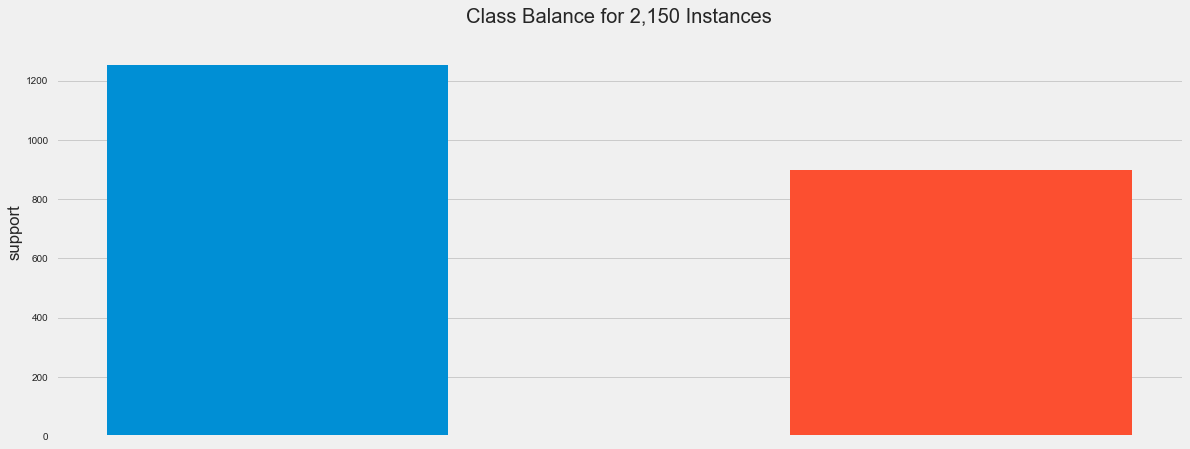

In [29]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=['', ''])

visualizer.fit(y) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

## Global Machine Learning Model
<a id='global_model_cell'></a>
Explain concept

### Model Selection
<a id='model_selection_cell'></a>

#### Selecting Columns 
<a id='column_selection_cell'></a>
From the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html):
> Create a callable to select columns to be used with ColumnTransformer.   
>   
>```make_column_selector``` can select columns based on datatype or the columns name with a regex. When using multiple selection criteria, all criteria must match for a column to be selected.

In [30]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1720, 17) (1720,)
(430, 17) (430,)


In [31]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

#### Selecting models to score
<a id='model_scoring_selection_cell'></a>

In [32]:
# list of models to use
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3, max_iter=2000),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]

In [33]:
# function to score models
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    Input: 
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [34]:
# function to visualize models
def visualize_model(X, y, estimator, **kwargs):
    """
    
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['False', 'True'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

#### Scoring selected models
<a id='scoring_models_cell'></a>

F1 SCORE SVC: 0.5778401122019635


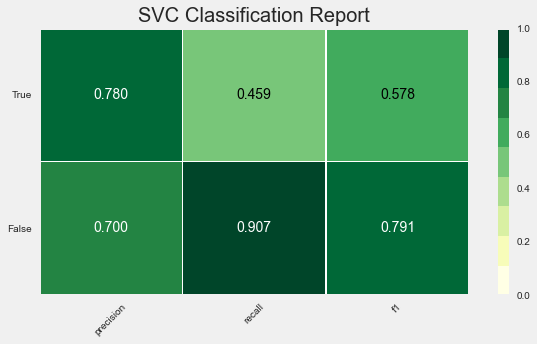

F1 SCORE NuSVC: 0.7694090382387022


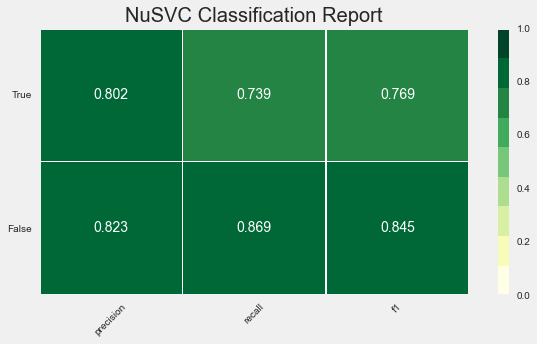

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 SCORE LinearSVC: 0.6839012925969448


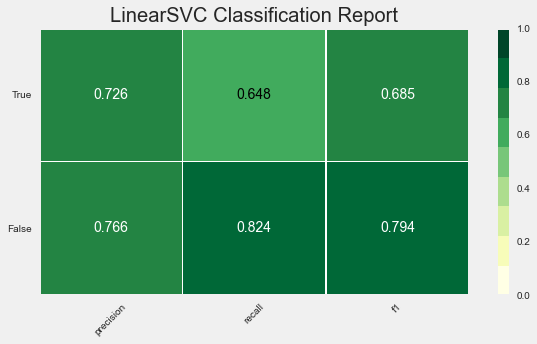

F1 SCORE SGDClassifier: 0.6473317865429234


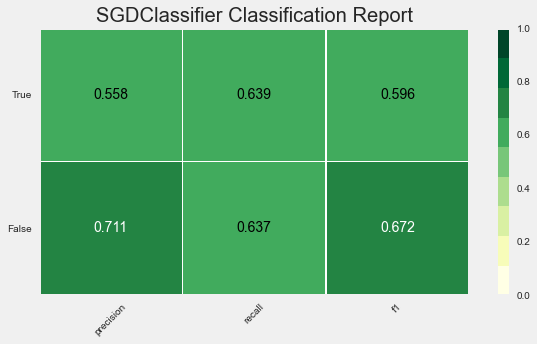

F1 SCORE KNeighborsClassifier: 0.7609195402298851


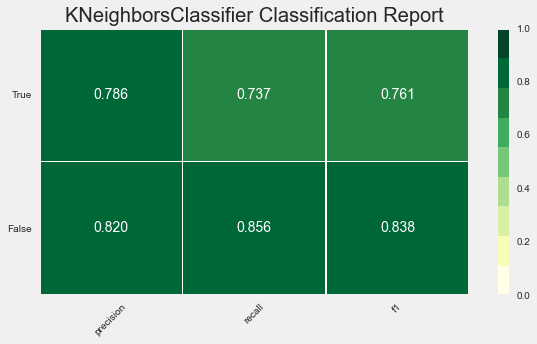

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

F1 SCORE LogisticRegression: 0.6799999999999999


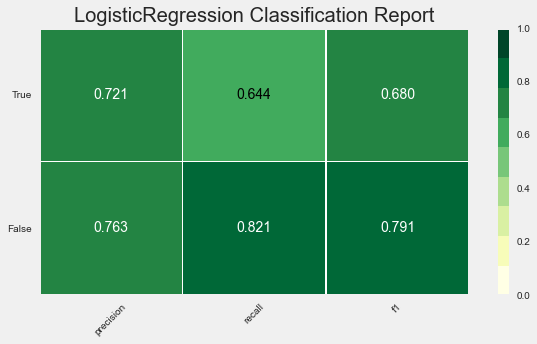

F1 SCORE LogisticRegressionCV: 0.48254931714719274


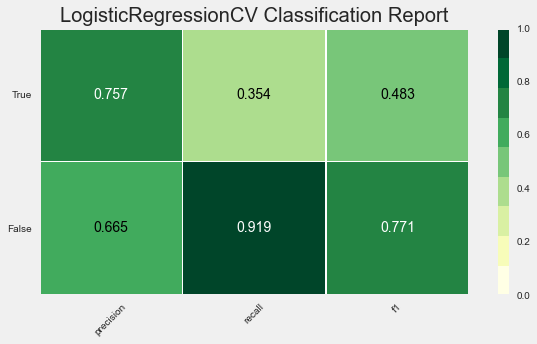

F1 SCORE BaggingClassifier: 1.0


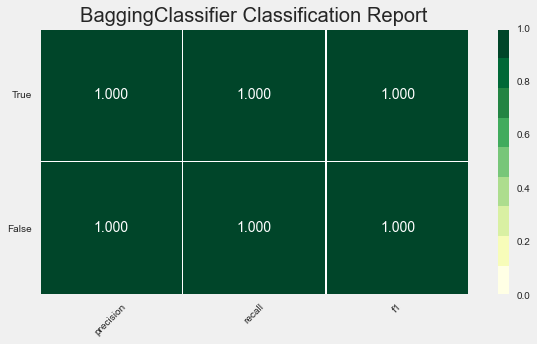

F1 SCORE ExtraTreesClassifier: 1.0


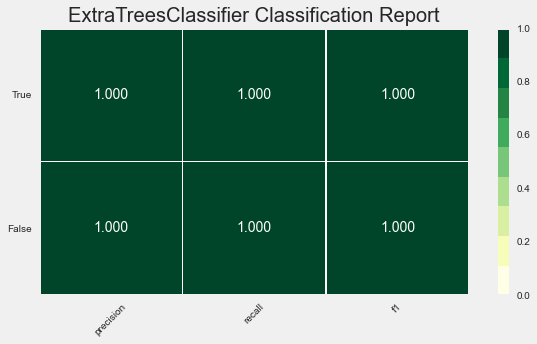

F1 SCORE RandomForestClassifier: 1.0


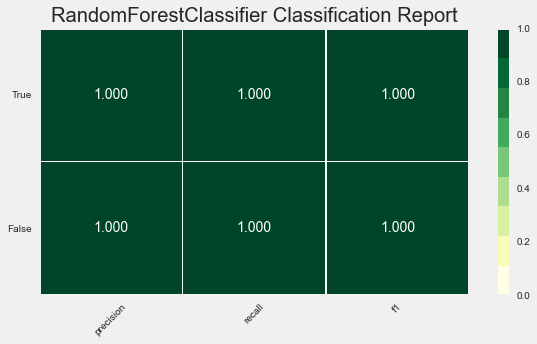

In [35]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

F1 SCORE SVC: 0.5301204819277109


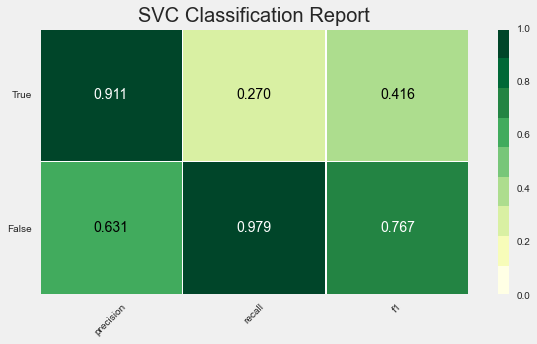

F1 SCORE NuSVC: 0.7709251101321587


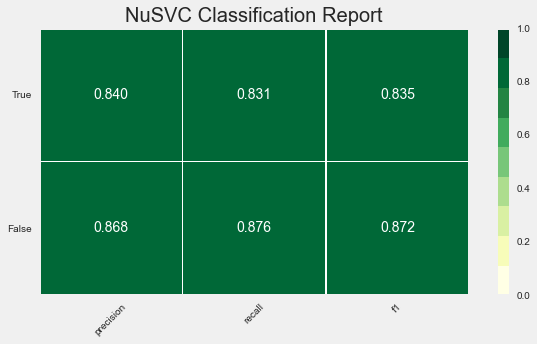

/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1 SCORE LinearSVC: 0.6866566716641679


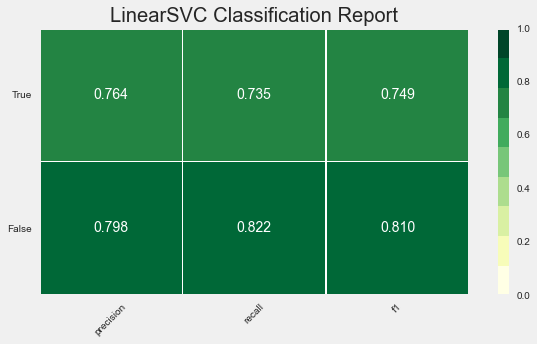

F1 SCORE SGDClassifier: 0.5674008810572687


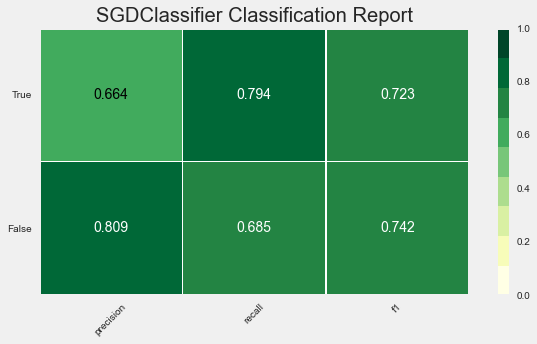

F1 SCORE KNeighborsClassifier: 0.7543103448275862


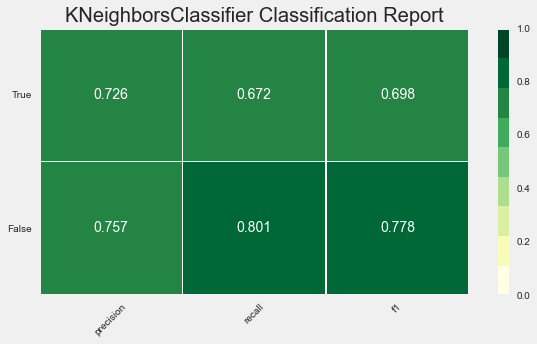

F1 SCORE LogisticRegression: 0.670196671709531


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


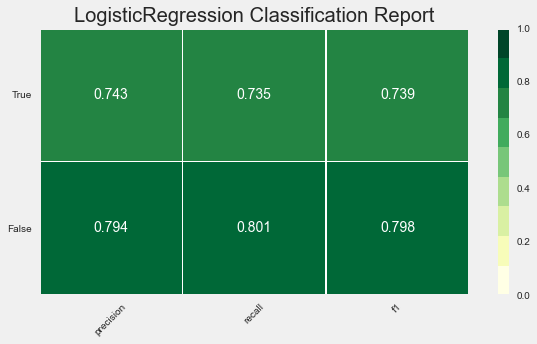

F1 SCORE LogisticRegressionCV: 0.6767143933685005


/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aidanoconnor/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

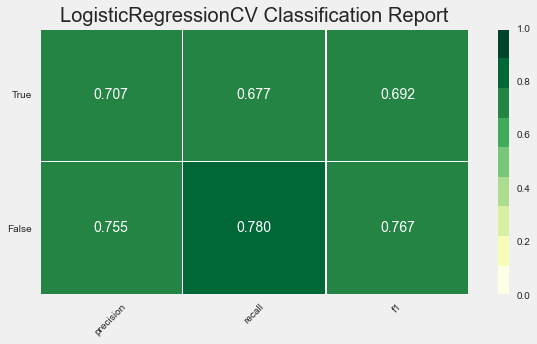

F1 SCORE BaggingClassifier: 0.9900426742532006


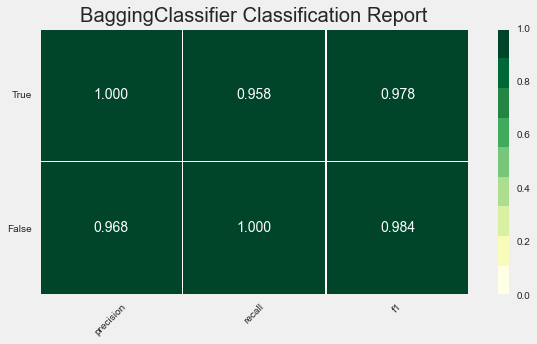

F1 SCORE ExtraTreesClassifier: 1.0


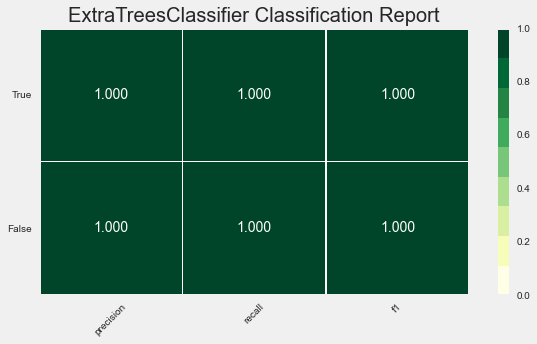

F1 SCORE RandomForestClassifier: 1.0


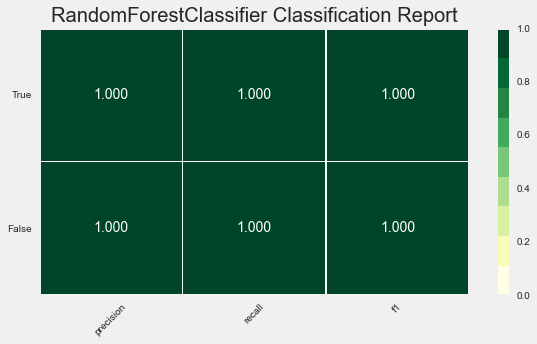

In [36]:
# iterate through list of models through both functions defined above
# Use X and y dataframes first, which contain all of the data
for model in models:
    score_model(X_train, y_train, model)
    visualize_model(X_test, y_test, model)

## Hyperparameter Tuning
<a id='hyperparameter_tuning_cell'></a>

## Title
<a id='header_cell'></a>